# Задание 

Задание 4. Построение предиктивной модели оценки надежности заемщика на основании бизнес-кейса крупного коммерческого банка.
Датасет для решения задачи  https://disk.yandex.ru/d/Em-zX3D2uZ4Nlg
1. Провести разведочный анализ данных по данным скоринга.
2. Определить достаточность данных для определения кредитного скоринга, социального скоринга.
Социальный скоринг — это вид скоринга, который оценивает клиента по его социальным характеристикам и прогнозирует его поведение с помощью анализа его присутствия в социальных сетях. Используя такие данные, как пол, возраст, место проживания, должность, длительность работы в одном месте и т.д

### Я тестировал, сохраняя совсем немного .pq файлов, потому что у меня все зависает T_T

# Импорт

In [3]:
import os
import pandas as pd
import re

train_folder = '../task4_data/train_data'

files = [f for f in os.listdir(train_folder) if f.endswith('.pq')]

def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

files_sorted = sorted(files, key=extract_number)

print(f"Всего файлов: {len(files_sorted)}")

Всего файлов: 12


In [4]:
df_list = []
for i in range(min(1, len(files_sorted))):
    path = os.path.join(train_folder, files_sorted[i])
    print(f"Читаю файл {i+1}: {files_sorted[i]}")
    df_part = pd.read_parquet(path, engine='fastparquet')
    print(f"Размер файла: {df_part.shape}")
    df_list.append(df_part)

Читаю файл 1: train_data_0.pq
Размер файла: (1974724, 61)


In [5]:
df_train = pd.concat(df_list, ignore_index=True)
print(f"Размер объединённого DataFrame: {df_train.shape}")

Размер объединённого DataFrame: (1974724, 61)


In [6]:
train_target = pd.read_csv('../task4_data/train_target.csv')
print(f"Размер меток: {train_target.shape}")

Размер меток: (3000000, 2)


In [7]:
df = df_train.merge(train_target, on='id', how='left')

# 1. Разведочный анализ (EDA)

In [17]:
df.shape

(1974724, 62)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 62 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

Проверка дубликатов и уникальности

In [20]:
print(f"Всего записей: {len(df_train)}")
print(f"Уникальных клиентов (id): {df_train['id'].nunique()}")
print(f"Среднее число кредитов на клиента: {len(df_train) / df_train['id'].nunique():.2f}")

Всего записей: 1974724
Уникальных клиентов (id): 250000
Среднее число кредитов на клиента: 7.90


Распределение целевой переменной (flag)

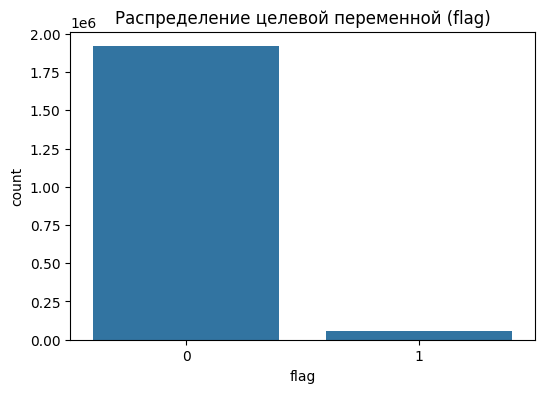

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='flag')
plt.title("Распределение целевой переменной (flag)")
plt.show()

Статистики по ключевым признакам

In [23]:
cols_to_analyze = [
    'pre_since_opened', 'pre_since_confirmed', 
    'pre_loans_credit_limit', 'pre_loans_total_overdue',
    'pre_loans_max_overdue_sum', 'pre_util'
]

df_train[cols_to_analyze].describe().T

,count,mean,std,min,25%,50%,75%,max
pre_since_opened,1974724.0,9.271325,5.773757,0.0,4.0,9.0,14.0,19.0
pre_since_confirmed,1974724.0,8.330264,4.593511,0.0,5.0,9.0,11.0,17.0
pre_loans_credit_limit,1974724.0,9.740888,5.799625,0.0,5.0,10.0,15.0,19.0
pre_loans_total_overdue,1974724.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pre_loans_max_overdue_sum,1974724.0,2.012115,0.334817,1.0,2.0,2.0,2.0,3.0
pre_util,1974724.0,13.934713,4.335488,0.0,16.0,16.0,16.0,19.0


Визуализация распределений

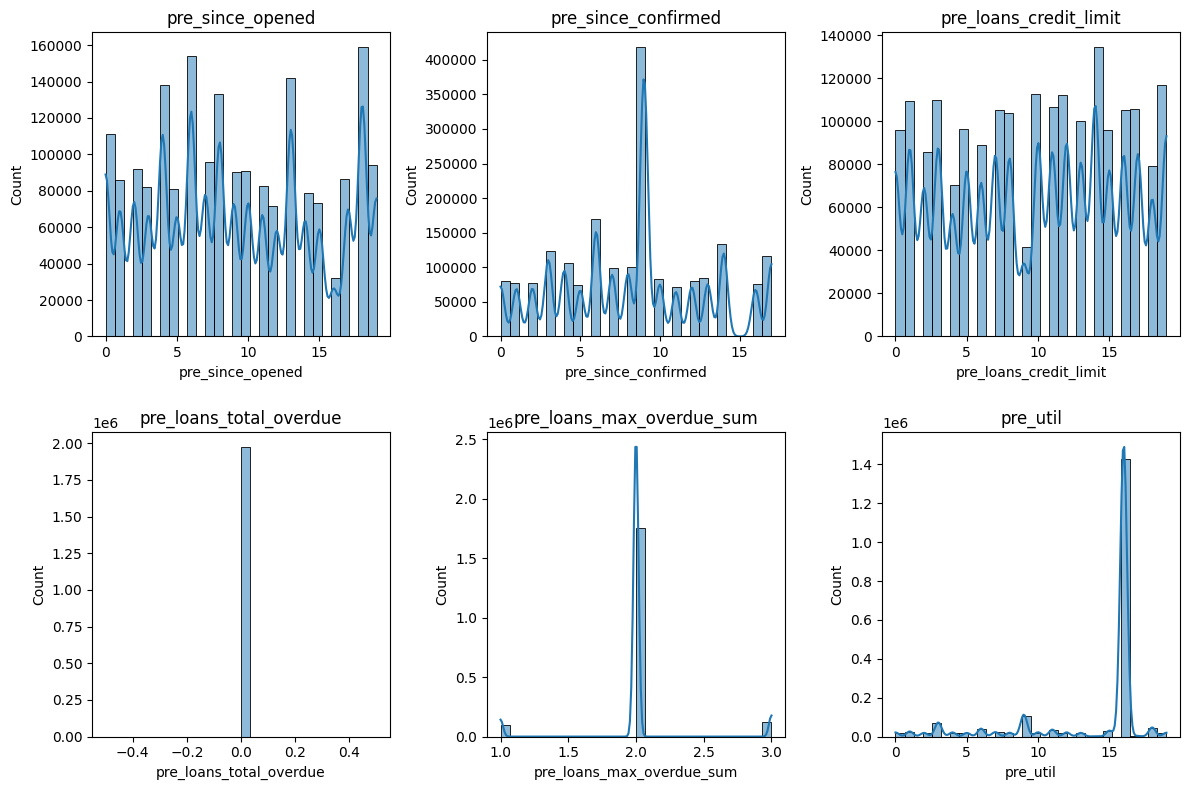

In [24]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(cols_to_analyze[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

Анализ категориальных и бинарных признаков

In [25]:
encoded_cols = [col for col in df_train.columns if col.startswith('enc_')]

for col in encoded_cols:
    print(f"\n--- {col} ---")
    print(df_train[col].value_counts().head())


--- enc_paym_0 ---
enc_paym_0
0    1791770
3      88319
1      87480
2       7155
Name: count, dtype: int64

--- enc_paym_1 ---
enc_paym_1
0    1635644
3     205080
1     124300
2       9700
Name: count, dtype: int64

--- enc_paym_2 ---
enc_paym_2
0    1556292
3     299304
1     110228
2       8900
Name: count, dtype: int64

--- enc_paym_3 ---
enc_paym_3
0    1474594
3     386940
1     104846
2       8344
Name: count, dtype: int64

--- enc_paym_4 ---
enc_paym_4
0    1383266
3     486048
1      97863
2       7547
Name: count, dtype: int64

--- enc_paym_5 ---
enc_paym_5
0    1300408
3     576932
1      90451
2       6933
Name: count, dtype: int64

--- enc_paym_6 ---
enc_paym_6
0    1181675
3     704689
1      82467
2       5893
Name: count, dtype: int64

--- enc_paym_7 ---
enc_paym_7
0    1093372
3     799529
1      76460
2       5363
Name: count, dtype: int64

--- enc_paym_8 ---
enc_paym_8
0    1021305
3     879207
1      69501
2       4711
Name: count, dtype: int64

--- enc_paym_9 ---

Бинарные флаги (is_zero_*)

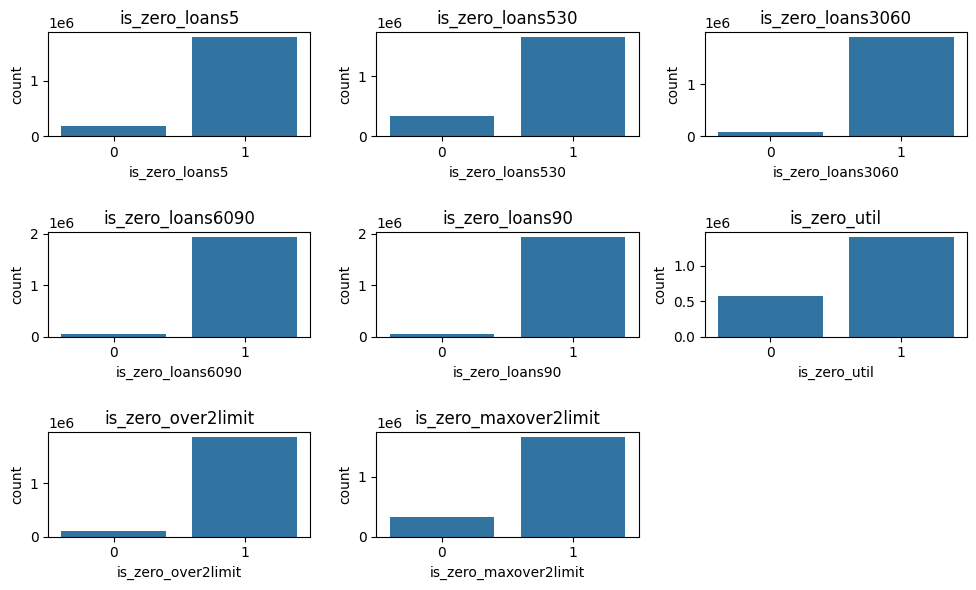

In [26]:
binary_cols = [col for col in df_train.columns if col.startswith('is_zero_')]

plt.figure(figsize=(10, 6))
for i, col in enumerate(binary_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df_train, x=col)
    plt.title(col)
plt.tight_layout()
plt.show()

Анализ временных признаков

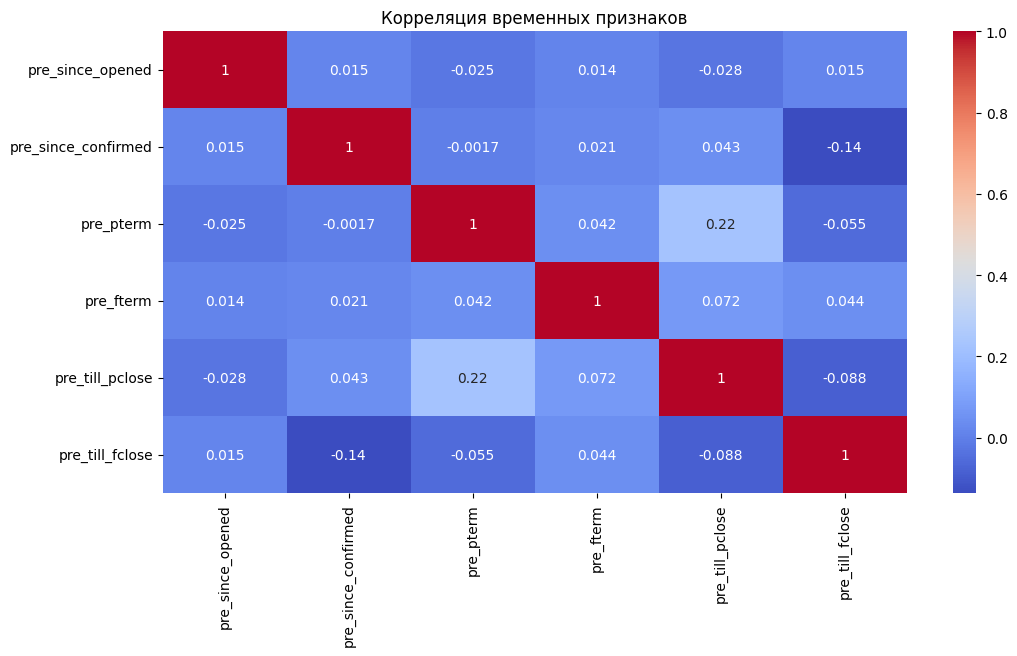

In [27]:
time_cols = [
    'pre_since_opened', 'pre_since_confirmed',
    'pre_pterm', 'pre_fterm',
    'pre_till_pclose', 'pre_till_fclose'
]

plt.figure(figsize=(12, 6))
sns.heatmap(df_train[time_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Корреляция временных признаков")
plt.show()

Анализ просрочек (pre_loans_*)

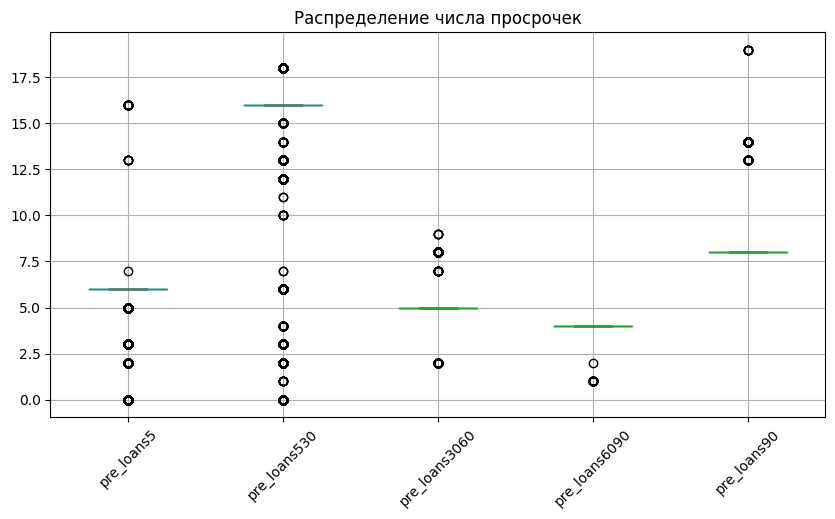

In [28]:
late_cols = [
    'pre_loans5', 'pre_loans530', 'pre_loans3060',
    'pre_loans6090', 'pre_loans90'
]

plt.figure(figsize=(10, 5))
df_train[late_cols].boxplot()
plt.title("Распределение числа просрочек")
plt.xticks(rotation=45)
plt.show()

Анализ корреляции с целевой переменной

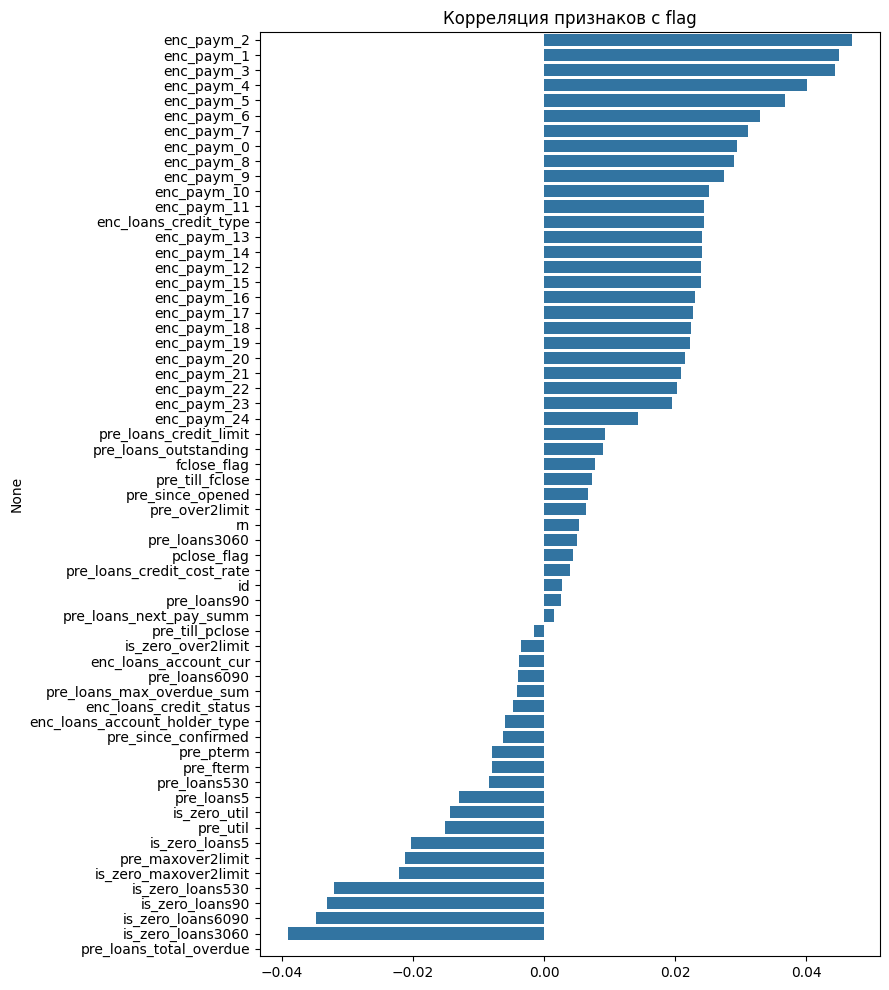

In [31]:
numeric_cols = df.select_dtypes(include=['int64']).columns.tolist()
corr_with_target = df[numeric_cols].corr()['flag'].sort_values(ascending=False)

corr_with_target = corr_with_target.drop('flag')

plt.figure(figsize=(8, 12))
sns.barplot(y=corr_with_target.index, x=corr_with_target.values)
plt.title("Корреляция признаков с flag")
plt.show()

# 2. Достаточность данных

1. Оценка данных для кредитного скоринга

Кредитный скоринг строится на:

    Истории платежей (просрочки, регулярность)

    Текущей задолженности (кредитный лимит, уровень утилизации)

    Длительности кредитной истории

    Количестве кредитных продуктов

Что есть в данных:
✔ pre_loans_total_overdue, pre_loans_max_overdue_sum – просрочки
✔ pre_loans_credit_limit, pre_util – кредитная нагрузка
✔ pre_since_opened, pre_since_confirmed – длительность истории
✔ pre_loans5, pre_loans530, pre_loans90 – градация просрочек

Чего не хватает:
❌ Данных о доходах (нет salary-полей)
❌ Семейного положения (женат/холост)
❌ Кредитной истории в других банках (только внутренние данные)

Вывод:
➡ Достаточно для базового скоринга, но без данных о доходах модель будет менее точной.

2. Оценка данных для социального скоринга

Социальный скоринг учитывает:

    Демографию (возраст, пол, город)

    Социальную активность (соцсети, поведение)

    Профессиональный статус (должность, стаж)

Что есть в данных:
✔ enc_loans_account_holder_type – тип держателя счета (возможно, физ/юр лицо)
✔ enc_loans_credit_type – тип кредита (может косвенно указывать на статус)

Чего не хватает:
❌ Прямых социальных данных (возраст, пол, соцсети)
❌ Геолокации (нет поля с городом/регионом)
❌ Профессиональных данных (должность, работодатель)

Вывод:
➡ Недостаточно для полноценного социального скоринга – нужны дополнительные источники (например, данные из соцсетей или анкет).

# Моделирование

Импорт крутой версии сбалансированного датасета

In [1]:
import pandas as pd

df_b = pd.read_csv('balanced_credit.csv')

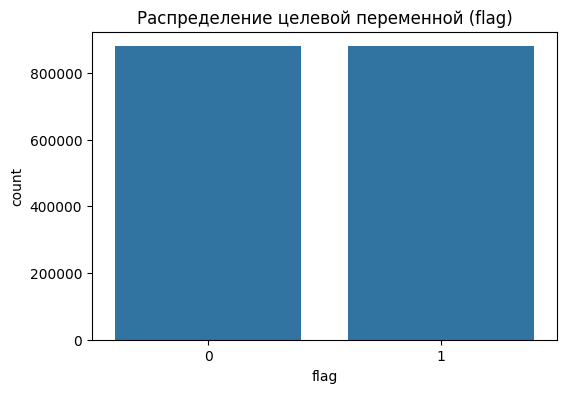

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df_b, x='flag')
plt.title("Распределение целевой переменной (flag)")
plt.show()

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

In [4]:
X = df_b.drop('flag', axis=1)
y = df_b['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
models = {
    # 'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    # 'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    # 'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    # 'XGBoost': XGBClassifier(scale_pos_weight=(y_train == 0).sum()/(y_train == 1).sum(), 
    #                         eval_metric='auc', random_state=42)
}

preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

results = {}

In [6]:
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    probas = pipeline.predict_proba(X_test)[:, 1]

    results[name] = {
        'ROC-AUC': roc_auc_score(y_test, probas),
        'F1-score': f1_score(y_test, preds),
        'Classification Report': classification_report(y_test, preds)
    }

In [7]:
for name, metrics in results.items():
    print(f"\n=== {name} ===")
    print(f"ROC-AUC: {metrics['ROC-AUC']:.3f}")
    print(f"F1-score: {metrics['F1-score']:.3f}")
    print("\nClassification Report:")
    print(metrics['Classification Report'])


=== Random Forest ===
ROC-AUC: 0.639
F1-score: 0.588

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61    175962
           1       0.61      0.57      0.59    175962

    accuracy                           0.60    351924
   macro avg       0.60      0.60      0.60    351924
weighted avg       0.60      0.60      0.60    351924

